# Semi Classifier 1

### Load required packages and functions

In [2]:
import cv2
import numpy as np
import pandas as pd
import numpy as np
from PIL import Image
#from resizeimage import resizeimage
import os
import re # 정규표현식을 사용해서 문자열 다루기 위한 라이브러리
import matplotlib
from matplotlib.pyplot import imshow # imageshow
from scipy.misc import imread, imresize # image read
from matplotlib import pyplot as plt# jjung : working directory 설정해서 사용하기
import h5py
from scipy.spatial.distance import pdist, squareform
import operator

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

def setpath(path):
    os.chdir(path)
    print(os.getcwd())
    
def get_index(name):
    name = str(name)
    p_s = re.compile("[0-9]+.jpeg")
    p_e = re.compile(".jpeg")

    m_s = p_s.search(name)
    m_e = p_e.search(name)

    return name[m_s.start():m_e.start()]

def get_index_raw(name):
    #p_start = re.compile("^[0]+") # 첫부분에 0이 하나이상 반복되는 패턴
    p_end = re.compile("(.jpg|.png|.jpeg)$", re.IGNORECASE)
    
    #return name[p_start.search(name).end():p_end.search(name).start()]
    return name[:p_end.search(name).start()]
    
def clear():
    # 전부 동일한 확장자 명으로 바꿔주기
    pattern = re.compile("(.JPG|.jpg)$", re.IGNORECASE) # .JPG  나 .jpg로 끝나는 패턴, ignorecase option을 붙이면 대소문자 구분없게 해주기 때문에 사실 jpg하나만 써주면 됨
    for fileName in os.listdir("."):
        check = pattern.search(fileName)
        if check :
            text_to_replace = check.group()
            os.rename(fileName, fileName.replace(text_to_replace, ext))

    # 이름 첫부분에 0이 하나이상 들어가는 것 바꿔주기 
    pattern  = re.compile("^[0]+") # 첫부분에 0이 하나이상 반복되는 패턴
    for fileName in os.listdir("."):
        check = pattern.search(fileName)
        if check :
            num_0 = check.end()
            os.rename(fileName, fileName[num_0:])
            
    # 기존에 만들어진 resize 이미지 일괄 삭제
    for fileName in os.listdir(".") :
        if fileName.startswith("resize") : os.remove(fileName)

def resize(path_images,path_reize, width, height):
    p = re.compile("(.jpg|.png|.jpeg)$", re.IGNORECASE)
    
    # make './resize' directory
    if not os.path.exists(path_resize):
        os.makedirs(path_resize)
        
    for fileName in os.listdir(path_images):
        if (p.search(fileName) and not fileName.startswith("resize")):
            img = Image.open(path_images + '/' + fileName)
            img = img.resize((width, height), Image.ANTIALIAS).convert('RGB')
            img.save(path_resize + '/' + 'resize' + get_index_raw(fileName) + '.jpeg')    
            
def getDB():
    labels = []
    for fileName in os.listdir(".") :
        if fileName.startswith("resize") :
            label = fileName[len("resize"):-5]  # -5 for ".jpeg"
            labels.append(label)
    print("number of images :",len(labels))
    return labels

def distance_ORB(img_1, img_2, n_feature, n_distance):
    # orb
    orb = cv2.ORB_create(nfeatures = n_feature)
    kp1, des1 = orb.detectAndCompute(img_1,None)
    kp2, des2 = orb.detectAndCompute(img_2,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # 거리계산
    sum=0
    for j in range(min(len(matches),n_distance)): # 만약 두 이미지가 너무 달라서 matches가 10개도 안 될 경우를 대비해 min() 사용 
        sum=sum+matches[j].distance
    average=sum/min(len(matches),n_distance)
    
    return average

    # Draw first 10 matches.
    #img = cv2.drawMatches(img_1,kp1,img_2,kp2,matches[:n_distance], None, flags=0)
    #plt.imshow(img),plt.show() 
     
class Cluster:
    def __init__(self):
        pass
    def __repr__(self):
        name_j = str(self.left)
        name_i = str(self.right)
        if(name_j.startswith('|')) : name_j = name_j[1:-1]
        if(name_i.startswith('|')) : name_i = name_i[1:-1]
        return '|%s,%s|' % (name_j, name_i)
    def add(self, clusters, grid, lefti, righti, case):
        self.left = clusters[lefti]
        self.right = clusters[righti]
        
        # merge columns grid[row][righti] and row grid[righti] into corresponding lefti
        if case == 'min' :
            for r in grid:
                r[lefti] = min([r[lefti], r.pop(righti)])
            grid[lefti] = list(map(min, zip(grid[lefti], grid.pop(righti))))
        elif case == 'max' :
            for r in grid:
                r[lefti] = max([r[lefti], r.pop(righti)])
            grid[lefti] = list(map(max, zip(grid[lefti], grid.pop(righti))))
        else :
            for r in grid:
                r[lefti] = np.mean([r[lefti], r.pop(righti)])
            grid[lefti] = list(map(np.mean, zip(grid[lefti], grid.pop(righti))))
        
        clusters.pop(righti)
        return (clusters, grid)
    
def agglomerate(path_img, name, grid, categories, end_n_category = 5, 
                end_bunchmin = 20, end_n_bunch = 8, show_image = False, case = 'mean'):
    print("start")
    """
    given a list of labels and a 2-D grid of distances, iteratively agglomerate
    hierarchical Cluster
    """
    clusters = name
    while len(clusters) > 1:
        # find 2 closest clusters
        distances = [(1, 0, grid[1][0])]
        for i,row in enumerate(grid[2:]):
            distances += [(i+2, j, c) for j,c in enumerate(row[:i+2])]
        j,i,value = min(distances, key=lambda x:x[2])
        
        # print image
        print("===============================")
        #print(clusters[j], clusters[i])
        name_j = str(clusters[j])
        name_i = str(clusters[i])
        if(name_j.startswith('|')) : name_j = name_j[1:-1]
        if(name_i.startswith('|')) : name_i = name_i[1:-1]
        
        if show_image : 
            img_1 = imread(path_img + "/" + "resize" + name_j.split(',')[0] + '.jpeg')
            img_2 = imread(path_img + "/" +"resize" + name_i.split(',')[0] + '.jpeg')
            plt.subplot(1, 2, 1)
            plt.imshow(img_1)
            plt.subplot(1, 2, 2)
            plt.imshow(img_2)
            plt.show()
        print("distance", value)

        # merge i<-j
        c = Cluster()
        clusters, grid = c.add(clusters, grid, i, j, case)
        clusters[i] = c
        
        # merge categories i <- j
        #print(i,j)
        categories[i] = categories[i] + categories[j]
        categories.pop(j)
        
        n_categories = list(map(lambda x : len(x), categories))
        n_bunch = sum(num >= end_bunchmin for num in n_categories)
        
        print("n_categories : ", len(n_categories))
        print("max in a category : ", max(list(map(lambda x : len(x), categories))))
        print("number of bunch have more element than ", end_bunchmin, ":", n_bunch)
        print("==="*10)
        
        if len(n_categories) <= end_n_category : break
        if n_bunch >= end_n_bunch : break


    #return clusters
    return categories

def tree_explore(path_imread, path_imwrite, cluster, hierachy, devide):
    #path_imread = '/Users/kimj0a/Documents/Project/yummy_project/database/1__downtauner_avocade__3/resize'
    #path_imwrite = '/Users/kimj0a/Documents/Project/yummy_project/database/1__downtauner_avocade__3/category'
    global category
    global n_category
    if(hasattr(cluster, 'left')): tree_explore(cluster.left, hierachy+1, devide)
    if(hasattr(cluster, 'right')): 
        if(hierachy < devide) : 
            print("Category ", category, ": total", n_category)
            print("=============================================")
            category = category + 1
            n_category = 0
        tree_explore(cluster.right, hierachy + 1, devide)
    if(not hasattr(cluster, 'left') and not hasattr(cluster, 'right')) :
        n_category += 1
        img = imread(path_imread + "/" +"resize" + cluster + '.jpeg')
        
        # show image
        #plt.imshow(img)
        #plt.show()
        #print(category, cluster)

        # save image
        directory = path_imwrite +'/' +  str(category)
        if not os.path.exists(directory):
            os.makedirs(directory)
        cv2.imwrite(directory + '/' + str(n_category)+"_resize" + cluster + '.jpeg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def categories_explore(path_imread, path_imwrite, clusters, n_category = 15) :
    n_showimage = 10
    col_showimage = 5
    min_showimage = 2

    clusters_sort = sorted(clusters, key = len, reverse = True)
    for i in range(len(clusters_sort)) :
        print("==="*10)
        print("category : ", i, " , number of elements : ", len(clusters_sort[i]))
        if i < n_category :
            directory = path_imwrite +'/' +  str(i)
        else :
            directory = path_imwrite +'/' +  'etc'
            
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        temp =[]
        for j in range(len(clusters_sort[i])) :
            name = clusters_sort[i][j]
            
            img = imread(path_imread + "/" +"resize" + name + '.jpeg')
            cv2.imwrite(directory + '/' + "resize" + name + '.jpeg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            
            if len(clusters_sort[i]) > min_showimage and j < n_showimage :
                plt.subplot(int(min(n_showimage,len(clusters_sort[i])) / col_showimage) +2, min(col_showimage, len(clusters_sort[i])), j+1)
                temp.append(name)
                plt.imshow(img)
        print(temp)
        plt.show()    

def set_standard_image(image_list, label):
    return list(map(lambda x: [str(x), str(label)], image_list))

def burger_KNN(indexes, dist, standard, max_distance, k) :
    """
    standard : imageindex / label / 
    """
    standard_to_i = []
    for elem_standard in standard :
        standard_to_i.append([i for i, index in enumerate(indexes) if index == elem_standard[0]][0])
    
    label_KNN = []
    count = 0
    
    for i, index in enumerate (indexes) :
        label = [elem[1] for i, elem in enumerate(standard) if elem[0]==index]
        if len(label) == 1 : 
            label_KNN.append(label[0])
        else :
            temp = []
            for ith in range(len(standard)) :
                # list_index, image_index, label, distance
                temp.append((standard_to_i[ith], standard[ith][0], standard[ith][1], dist[i][standard_to_i[ith]]))
            
            temp_sort = sorted(temp, key = lambda x:x[3])
            nn_labels = [elem[2] for i, elem in enumerate(temp_sort) if (elem[3] <= max_distance and i < k)]
            
            unique = dict((alabel, nn_labels.count(alabel)) for alabel in nn_labels)
            sorted_unique = sorted(unique.items(), key=operator.itemgetter(1), reverse = True)
            frequent_label = ""
            if len(sorted_unique) == 1 :
                frequent_label = sorted_unique[0][0]
            elif len(sorted_unique) >= 2 :
                if sorted_unique[0][1] > sorted_unique[1][1] :
                    frequent_label = sorted_unique[0][0]
            
            label_KNN.append(frequent_label)
                    
    return label_KNN


def save_images_in_category(path_imread, path_imwrite, indexes, labels) :
    for i in range(len(indexes)) :
        if labels[i] == "" :
            directory = path_imwrite +'/' +  'notsure'
        else :
            directory = path_imwrite +'/' +  labels[i]
        
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        name = indexes[i]
        img = imread(path_imread + "/" +"resize" + name + '.jpeg')
        cv2.imwrite(directory + '/' + "resize" + name + '.jpeg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

### load tsne function

In [3]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python 2.7.10, and it requires a working
# installation of NumPy. The implementation comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as Math
import pylab as Plot

def Hbeta(D = Math.array([]), beta = 1.0):
	"""Compute the perplexity and the P-row for a specific value of the precision of a Gaucssian distribution."""

	# Compute P-row and corresponding perplexity
	P = Math.exp(-D.copy() * beta);
	sumP = sum(P);
	H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
	P = P / sumP;
	return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
	"""Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

	# Initialize some variables
	print ("Computing pairwise distances...")
	(n, d) = X.shape;
	sum_X = Math.sum(Math.square(X), 1);
	D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
	P = Math.zeros((n, n));
	beta = Math.ones((n, 1));
	logU = Math.log(perplexity);

	# Loop over all datapoints
	for i in range(n):

		# Print progress
		if i % 500 == 0:
			print ("Computing P-values for point ", i, " of ", n, "...")

		# Compute the Gaussian kernel and entropy for the current precision
		betamin = -Math.inf;
		betamax =  Math.inf;
		Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
		(H, thisP) = Hbeta(Di, beta[i]);

		# Evaluate whether the perplexity is within tolerance
		Hdiff = H - logU;
		tries = 0;
		while Math.abs(Hdiff) > tol and tries < 50:

			# If not, increase or decrease precision
			if Hdiff > 0:
				betamin = beta[i].copy();
				if betamax == Math.inf or betamax == -Math.inf:
					beta[i] = beta[i] * 2;
				else:
					beta[i] = (beta[i] + betamax) / 2;
			else:
				betamax = beta[i].copy();
				if betamin == Math.inf or betamin == -Math.inf:
					beta[i] = beta[i] / 2;
				else:
					beta[i] = (beta[i] + betamin) / 2;

			# Recompute the values
			(H, thisP) = Hbeta(Di, beta[i]);
			Hdiff = H - logU;
			tries = tries + 1;

		# Set the final row of P
		P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

	# Return final P-matrix
	print ("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)));
	return P;


def pca(X = Math.array([]), no_dims = 50):
	"""Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

	print ("Preprocessing the data using PCA...")
	(n, d) = X.shape;
	X = X - Math.tile(Math.mean(X, 0), (n, 1));
	(l, M) = Math.linalg.eig(Math.dot(X.T, X));
	Y = Math.dot(X, M[:,0:no_dims]);
	return Y;


def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
	"""Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
	The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

	# Check inputs
	if isinstance(no_dims, float):
		print ("Error: array X should have type float.");
		return -1;
	if round(no_dims) != no_dims:
		print ("Error: number of dimensions should be an integer.");
		return -1;

	# Initialize variables
	X = pca(X, initial_dims).real;
	(n, d) = X.shape;
	max_iter = 1000;
	initial_momentum = 0.5;
	final_momentum = 0.8;
	eta = 500;
	min_gain = 0.01;
	Y = Math.random.randn(n, no_dims);
	dY = Math.zeros((n, no_dims));
	iY = Math.zeros((n, no_dims));
	gains = Math.ones((n, no_dims));

	# Compute P-values
	P = x2p(X, 1e-5, perplexity);
	P = P + Math.transpose(P);
	P = P / Math.sum(P);
	P = P * 4;									# early exaggeration
	P = Math.maximum(P, 1e-12);

	# Run iterations
	for iter in range(max_iter):

		# Compute pairwise affinities
		sum_Y = Math.sum(Math.square(Y), 1);
		num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
		num[range(n), range(n)] = 0;
		Q = num / Math.sum(num);
		Q = Math.maximum(Q, 1e-12);

		# Compute gradient
		PQ = P - Q;
		for i in range(n):
			dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);

		# Perform the update
		if iter < 20:
			momentum = initial_momentum
		else:
			momentum = final_momentum
		gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
		gains[gains < min_gain] = min_gain;
		iY = momentum * iY - eta * (gains * dY);
		Y = Y + iY;
		Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

		# Compute current value of cost function
		if (iter + 1) % 10 == 0:
			C = Math.sum(P * Math.log(P / Q));
			print ("Iteration ", (iter + 1), ": error is ", C)

		# Stop lying about P-values
		if iter == 100:
			P = P / 4;

	# Return solution
	return Y;


#if __name__ == "__main__":
#	print ("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
#	print ("Running example on 2,500 MNIST digits...")
#	X = Math.loadtxt("mnist2500_X.txt");
#	labels = Math.loadtxt("mnist2500_labels.txt");
#	Y = tsne(X, 2, 50, 20.0);
#	Plot.scatter(Y[:,0], Y[:,1], 20, labels);
#	Plot.show();

## Step 1. Resizing Images

From crawling raw images ***.jpg, .jpeg, .png** , generate resizing images ***.jpeg**

In [4]:
working_dir = '/Users/haewonpark/Projects/handson/Image_Clustering_cnn/'

path_images = working_dir + '/images'
path_resize = working_dir + '/resize'

In [5]:
# resizing
setpath(path_images)
#clear()
resize(path_images, path_resize, 299,299)

/Users/haewonpark/Projects/handson/Image_Clustering_cnn/images


## Step 2. Calculate feature vector from inception_v4 model using TF_exractor
```bash
$ python example_feat_extract.py --network inception_v4 --checkpoint ./checkout/inception_v4.ckpt --image_path ./mini/ --out_file ./mini_features.h5 --layer_names Logits
```

In [6]:
path_features = '/Users/haewonpark/Projects/handson/TF_FeatureExtraction'
setpath(path_features)

/Users/haewonpark/Projects/handson/TF_FeatureExtraction


In [7]:
import sys
#sys.path.append("/Users/"+username+"/Projects/keras_talk/models/research/slim")
sys.path.append("/Users/haewonpark/Projects/handson/models/research/slim")
import nets

In [13]:
%run example_feat_extract.py --network inception_v4 --checkpoint ./checkpoints/inception_v4.ckpt --image_path /Users/haewonpark/Projects/handson/Image_Clustering_cnn/images/ --out_file /Users/haewonpark/Projects/handson/Image_Clustering_cnn/burger_inceptionV4.h5 --layer_names AuxLogits,global_pool,PreLogitsFlatten,Logits

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./checkpoints/inception_v4.ckpt
Conv2d_1a_3x3 has shape (?, 149, 149, 32)
Conv2d_2a_3x3 has shape (?, 147, 147, 32)
Conv2d_2b_3x3 has shape (?, 147, 147, 64)
Mixed_3a has shape (?, 73, 73, 160)
Mixed_4a has shape (?, 71, 71, 192)
Mixed_5a has shape (?, 35, 35, 384)
Mixed_5b has shape (?, 35, 35, 384)
Mixed_5c has shape (?, 35, 35, 384)
Mixed_5d has shape (?, 35, 35, 384)
Mixed_5e has shape (?, 35, 35, 384)
Mixed_6a has shape (?, 17, 17, 1024)
Mixed_6b has shape (?, 17, 17, 1024)
Mixed_6c has shape (?, 17, 17, 1024)
Mixed_6d has shape (?, 17, 17, 1024)
Mixed_6e has shape (?, 17, 17, 1024)
Mixed_6f has shape (?, 17, 17, 1024)
Mixed_6g has shape (?, 17, 17, 1024)
Mixed_6h has shape (?, 17, 17, 1024)
Mixed_7a has shape (?, 8, 8, 1536)
Mixed_7b has shape (?, 8, 8, 1536)
Mixed_7c has shape (?, 8, 8, 1536)
Mixed_7d has shape (?, 8, 8, 1536)
AuxLogits has shape (?, 1001)
global_pool has shape (?, 1, 1, 1

## Step 3. Load feature vector

In [8]:
# Load feature vector .h5 file 
path_fv = working_dir
file_fv = 'burger_inceptionV4.h5'
path_label = '/Users/haewonpark/Projects/handson/Image_Clustering_cnn/category_human'

features = h5py.File(path_fv + '/' + file_fv, 'r')
print("Load feacture vectors from ", path_fv + '/' + file_fv)

features_key = list(features.keys())
print("Available feature layer :", features_key)

# get feature vector at a layer
layer = 'Logits' # or features_key[?]
print("==="*30)
print("Selected layer : ", layer)

features_value = features[layer][...]
a = np.array(features_value)
features_value = np.reshape(a, (a.shape[0], -1)) #depth가 1보다 클 때 depth 1의 벡터로 전환

features_filename = features['filenames'][...]
features_index = list(map(get_index, features_filename))

feat_cols = ['feature' + str(i) for i in range(features_value.shape[1])]
df = pd.DataFrame(features_value, columns = feat_cols)
df['index'] = features_index

print("# of images : ", df.shape[0], ", # of features : ", len(feat_cols))

min_value = np.amin(df[feat_cols].values)
max_value = np.amax(df[feat_cols].values)
print("min feature value:", min_value, ", max feature value: ", max_value)

#df[feat_cols] = df[feat_cols] - np.amin(df[feat_cols].values)
#print("min :", np.amin(df[feat_cols].values), "max : ", np.max(df[feat_cols].values))
df[feat_cols] = df[feat_cols] / 10
print("min :", np.amin(df[feat_cols].values), "max : ", np.max(df[feat_cols].values))

Load feacture vectors from  /Users/haewonpark/Projects/handson/Image_Clustering_cnn//burger_inceptionV4.h5
Available feature layer : ['AuxLogits', 'Logits', 'PreLogitsFlatten', 'filenames', 'global_pool']
Selected layer :  Logits
# of images :  1478 , # of features :  1001
min feature value: -4.622076 , max feature value:  13.508808
min : -0.46220762 max :  1.3508809


In [9]:
# check is any null value in dataframe
df[df.isnull().T.any().T]

Empty DataFrame
Columns: [feature0, feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10, feature11, feature12, feature13, feature14, feature15, feature16, feature17, feature18, feature19, feature20, feature21, feature22, feature23, feature24, feature25, feature26, feature27, feature28, feature29, feature30, feature31, feature32, feature33, feature34, feature35, feature36, feature37, feature38, feature39, feature40, feature41, feature42, feature43, feature44, feature45, feature46, feature47, feature48, feature49, feature50, feature51, feature52, feature53, feature54, feature55, feature56, feature57, feature58, feature59, feature60, feature61, feature62, feature63, feature64, feature65, feature66, feature67, feature68, feature69, feature70, feature71, feature72, feature73, feature74, feature75, feature76, feature77, feature78, feature79, feature80, feature81, feature82, feature83, feature84, feature85, feature86, feature87, feature88, feature89, feature90, feature91, feature92, feature93, feature94, feature95, feature96, feature97, feature98, feature99, ...]
Index: []

[0 rows x 1002 columns]

## Step 4. Calculate feature distances

In [10]:
# euclidean distance
distances = squareform(pdist(df[feat_cols].values.tolist(), 'euclidean'))

## Step 5. Agglomerative clustering

In [11]:
categories = list(map(lambda x : [x], df['index'].values.tolist()))
path_img = working_dir + '/resize'

clusters = agglomerate(path_img, df['index'].values.tolist(), distances.tolist(), categories, 
                       end_n_category = 15, end_bunchmin = 5, end_n_bunch = 20, 
                       show_image = False, case = 'max')

start
distance 0.48586371420852825
n_categories :  1477
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.49608975986541365
n_categories :  1476
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.5095147342674331
n_categories :  1475
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.5157508230394726
n_categories :  1474
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.5415247934306414
n_categories :  1473
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.5696934588431719
n_categories :  1472
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.5884036735966998
n_categories :  1471
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.598928075923988
n_categories :  1470
max in a category :  2
number of bunch have more element than  5 : 0
distance 0.5991132561685363
n_categories :  1469


distance 0.8220784923031224
n_categories :  1431
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8281227046909433
n_categories :  1430
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8316092213936727
n_categories :  1429
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8332349361669275
n_categories :  1428
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8448226490679982
n_categories :  1427
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8478022651921641
n_categories :  1426
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8484337777117732
n_categories :  1425
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8556117057178008
n_categories :  1424
max in a category :  4
number of bunch have more element than  5 : 0
distance 0.8698313197209494
n_categories :  1423
max in 

distance 0.9783554021995825
n_categories :  1385
max in a category :  6
number of bunch have more element than  5 : 3
distance 0.9850278772237233
n_categories :  1384
max in a category :  6
number of bunch have more element than  5 : 3
distance 0.9862823440084242
n_categories :  1383
max in a category :  6
number of bunch have more element than  5 : 3
distance 0.9868153454009052
n_categories :  1382
max in a category :  6
number of bunch have more element than  5 : 3
distance 0.9900002835795078
n_categories :  1381
max in a category :  6
number of bunch have more element than  5 : 3
distance 0.9972020189502153
n_categories :  1380
max in a category :  6
number of bunch have more element than  5 : 3
distance 0.9992311301581215
n_categories :  1379
max in a category :  6
number of bunch have more element than  5 : 3
distance 1.0052505762212915
n_categories :  1378
max in a category :  6
number of bunch have more element than  5 : 3
distance 1.0067407491431872
n_categories :  1377
max in 

distance 1.120661887478207
n_categories :  1339
max in a category :  8
number of bunch have more element than  5 : 6
distance 1.1224568171450906
n_categories :  1338
max in a category :  8
number of bunch have more element than  5 : 6
distance 1.1230355484000145
n_categories :  1337
max in a category :  8
number of bunch have more element than  5 : 6
distance 1.1236110113659763
n_categories :  1336
max in a category :  8
number of bunch have more element than  5 : 6
distance 1.1236410101302674
n_categories :  1335
max in a category :  11
number of bunch have more element than  5 : 5
distance 1.1239278674095337
n_categories :  1334
max in a category :  11
number of bunch have more element than  5 : 5
distance 1.1257330245266544
n_categories :  1333
max in a category :  11
number of bunch have more element than  5 : 5
distance 1.1264049892285122
n_categories :  1332
max in a category :  11
number of bunch have more element than  5 : 5
distance 1.1264056782932812
n_categories :  1331
max 

distance 1.2268253723650062
n_categories :  1293
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.2293327874894098
n_categories :  1292
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.237293725034383
n_categories :  1291
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.23941672714288
n_categories :  1290
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.2406764244022
n_categories :  1289
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.241381398383375
n_categories :  1288
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.2424028188225489
n_categories :  1287
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.2455825129710936
n_categories :  1286
max in a category :  11
number of bunch have more element than  5 : 8
distance 1.24920666795928
n_categories :  1285
max in a

distance 1.3143144120881893
n_categories :  1248
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.3208998056648686
n_categories :  1247
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.323464984354189
n_categories :  1246
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.3241003967145355
n_categories :  1245
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.3253884402959248
n_categories :  1244
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.3279902290086485
n_categories :  1243
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.3312903906363949
n_categories :  1242
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.3348742475296842
n_categories :  1241
max in a category :  12
number of bunch have more element than  5 : 12
distance 1.3368324682186843
n_categories 

distance 1.3927997709393145
n_categories :  1203
max in a category :  12
number of bunch have more element than  5 : 14
distance 1.3946363141272016
n_categories :  1202
max in a category :  12
number of bunch have more element than  5 : 14
distance 1.395692592366682
n_categories :  1201
max in a category :  12
number of bunch have more element than  5 : 15
distance 1.3958443981027298
n_categories :  1200
max in a category :  12
number of bunch have more element than  5 : 16
distance 1.3959530728483376
n_categories :  1199
max in a category :  13
number of bunch have more element than  5 : 15
distance 1.3987898804604035
n_categories :  1198
max in a category :  13
number of bunch have more element than  5 : 15
distance 1.3989447824939876
n_categories :  1197
max in a category :  13
number of bunch have more element than  5 : 15
distance 1.3994511575170954
n_categories :  1196
max in a category :  13
number of bunch have more element than  5 : 15
distance 1.3996976197074762
n_categories 

distance 1.4663756233763678
n_categories :  1158
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.4667087231785039
n_categories :  1157
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.4668809092271993
n_categories :  1156
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.467097086791304
n_categories :  1155
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.4697823239870194
n_categories :  1154
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.471191039844338
n_categories :  1153
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.4713397317298798
n_categories :  1152
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.4745588407291015
n_categories :  1151
max in a category :  23
number of bunch have more element than  5 : 12
distance 1.4752656530772248
n_categories :

distance 1.519545996226842
n_categories :  1113
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5199330190511933
n_categories :  1112
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5225367351555823
n_categories :  1111
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5255559094021887
n_categories :  1110
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5264010265827452
n_categories :  1109
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5278839344180288
n_categories :  1108
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5280325481994554
n_categories :  1107
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5307017551437323
n_categories :  1106
max in a category :  23
number of bunch have more element than  5 : 15
distance 1.5308623179564549
n_categories 

distance 1.5846828726838
n_categories :  1068
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.5853357090000366
n_categories :  1067
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.5937851050713023
n_categories :  1066
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.5950322502042482
n_categories :  1065
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.5951620186359345
n_categories :  1064
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.596328970602574
n_categories :  1063
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.5982081441733527
n_categories :  1062
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.5983717863418385
n_categories :  1061
max in a category :  23
number of bunch have more element than  5 : 18
distance 1.598640944387348
n_categories :  1

n_categories :  1023
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.6334339741334836
n_categories :  1022
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.634401523045971
n_categories :  1021
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.6384931895111594
n_categories :  1020
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.6390329160023351
n_categories :  1019
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.6391123848907694
n_categories :  1018
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.6394322452297503
n_categories :  1017
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.6399560968926283
n_categories :  1016
max in a category :  23
number of bunch have more element than  5 : 19
distance 1.6400746347916786
n_categories :  1015
max in a category : 

### Check clustering images and save images

category :  0  , number of elements :  23


/Users/haewonpark/Projects/handson/venv/lib/python3.6/site-packages/ipykernel_launcher.py:248: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


['104', '39', '253', '96', '112', '378', '483', '210', '200', '51']


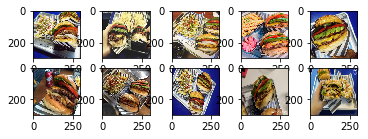

category :  1  , number of elements :  19
['107', '215', '406', '365', '714', '446', '88', '132', '32', '90']


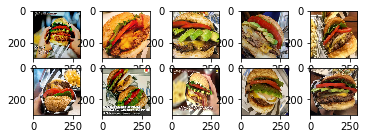

category :  2  , number of elements :  15
['149', '684', '213', '370', '274', '449', '442', '91', '175', '643']


category :  3  , number of elements :  15
['450', '443', '467', '460', '144', '703', '652', '712', '560', '564']


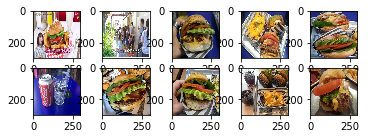

category :  4  , number of elements :  10
['123', '484', '477', '407', '401', '444', '497', '60', '512', '739']


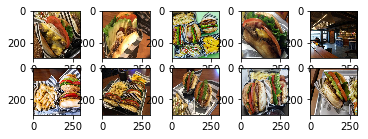

category :  5  , number of elements :  9
['103', '79', '122', '455', '76', '137', '533', '255', '170']


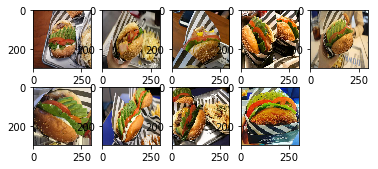

category :  6  , number of elements :  9
['106', '2', '556', '125', '248', '412', '48', '507', '58']


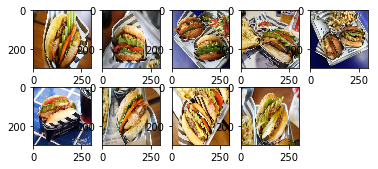

category :  7  , number of elements :  9
['148', '719', '313', '393', '567', '692', '69', '485', '478']


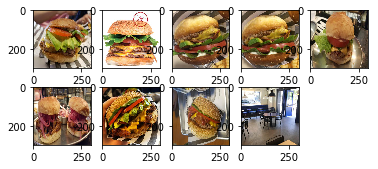

category :  8  , number of elements :  9
['182', '648', '668', '659', '252', '246', '270', '466', '459']


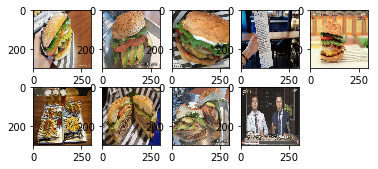

category :  9  , number of elements :  7
['10', '78', '237', '705', '709', '700', '410']


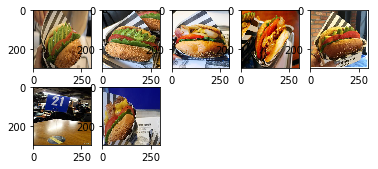

category :  10  , number of elements :  7
['169', '387', '194', '231', '389', '418', '344']


category :  11  , number of elements :  7
['397', '391', '134', '566', '559', '500', '729']


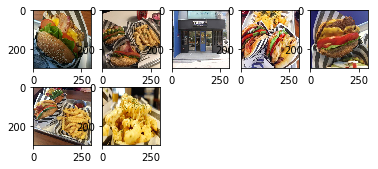

category :  12  , number of elements :  6
['177', '208', '319', '347', '424', '500']


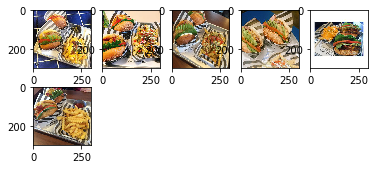

category :  13  , number of elements :  6
['179', '346', '435', '701', '715', '706']


category :  14  , number of elements :  6
['223', '56', '707', '289', '330', '283']


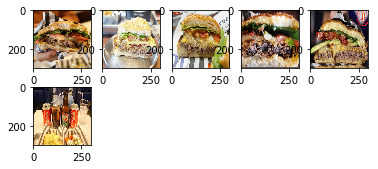

category :  15  , number of elements :  5
['139', '272', '508', '98', '658']


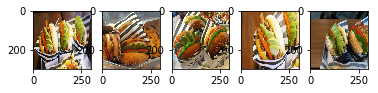

category :  16  , number of elements :  5
['217', '677', '227', '733', '299']


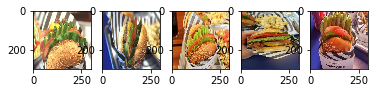

category :  17  , number of elements :  5
['338', '441', '486', '624', '595']


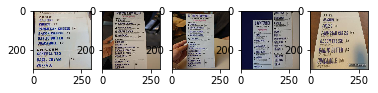

category :  18  , number of elements :  5
['419', '340', '129', '51', '683']


category :  19  , number of elements :  5
['529', '522', '534', '639', '731']


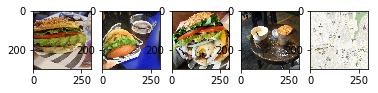

category :  20  , number of elements :  4
['110', '671', '666', '83']


category :  21  , number of elements :  4
['116', '113', '130', '127']


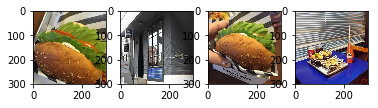

category :  22  , number of elements :  4
['152', '235', '550', '84']


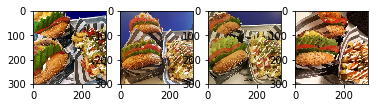

category :  23  , number of elements :  4
['167', '70', '465', '9']


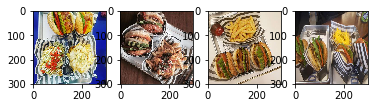

category :  24  , number of elements :  4
['204', '199', '359', '453']


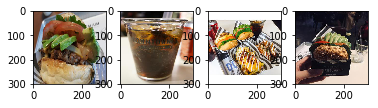

category :  25  , number of elements :  4
['232', '552', '44', '44']


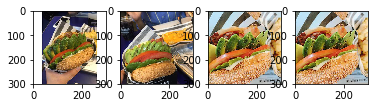

category :  26  , number of elements :  4
['240', '234', '75', '328']


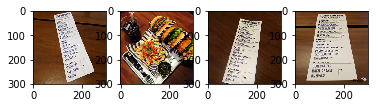

category :  27  , number of elements :  4
['308', '302', '540', '533']


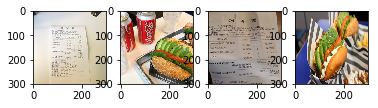

category :  28  , number of elements :  4
['320', '50', '573', '77']


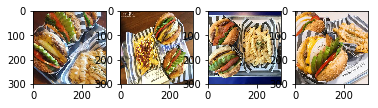

category :  29  , number of elements :  4
['93', '91', '284', '696']


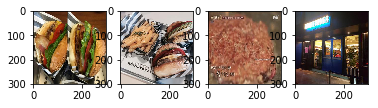

category :  30  , number of elements :  3
['140', '477', '579']


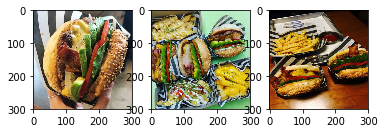

category :  31  , number of elements :  3
['143', '140', '423']


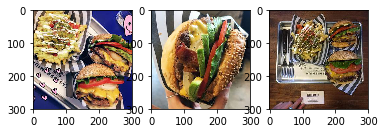

category :  32  , number of elements :  3
['151', '191', '422']


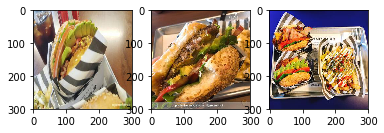

category :  33  , number of elements :  3
['21', '454', '447']


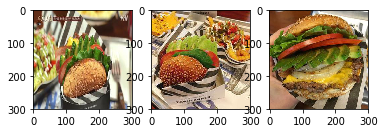

category :  34  , number of elements :  3
['222', '217', '574']


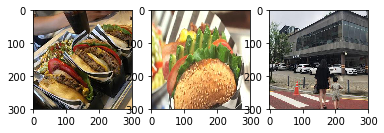

category :  35  , number of elements :  3
['225', '259', '553']


category :  36  , number of elements :  3
['257', '251', '77']


category :  37  , number of elements :  3
['292', '482', '511']


category :  38  , number of elements :  3
['303', '297', '334']


category :  39  , number of elements :  3
['314', '308', '466']


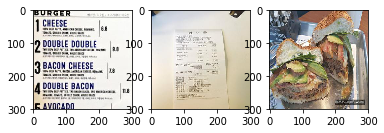

category :  40  , number of elements :  3
['334', '172', '493']


category :  41  , number of elements :  3
['354', '723', '576']


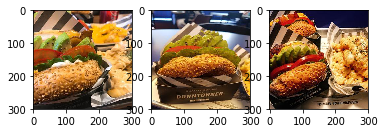

category :  42  , number of elements :  3
['373', '210', '716']


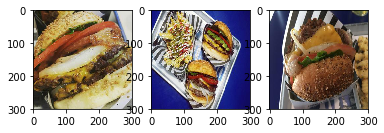

category :  43  , number of elements :  3
['437', '742', '57']


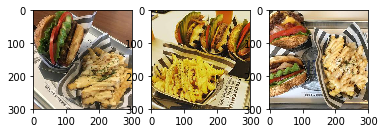

category :  44  , number of elements :  3
['53', '53', '439']


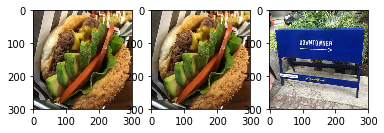

category :  45  , number of elements :  3
['588', '581', '698']


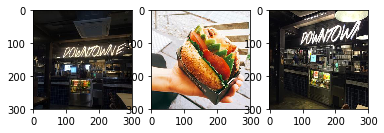

category :  46  , number of elements :  3
['672', '663', '427']


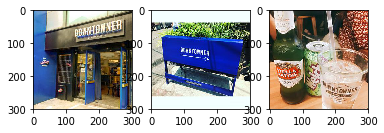

category :  47  , number of elements :  3
['101', '94', '476']


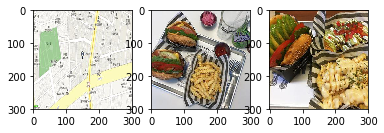

category :  48  , number of elements :  3
['189', '633', '76']


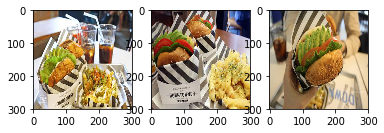

category :  49  , number of elements :  3
['208', '412', '501']


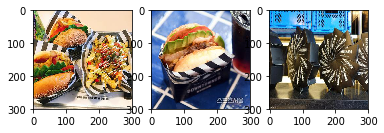

category :  50  , number of elements :  3
['307', '387', '428']


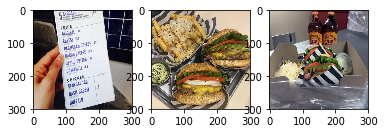

category :  51  , number of elements :  3
['56', '698', '69']


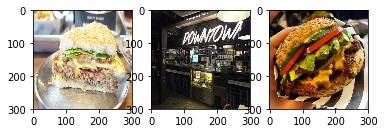

category :  52  , number of elements :  3
['634', '643', '723']


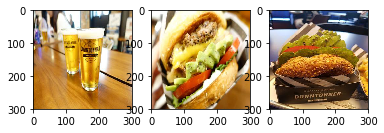

category :  53  , number of elements :  2
[]
category :  54  , number of elements :  2
[]
category :  55  , number of elements :  2
[]
category :  56  , number of elements :  2
[]
category :  57  , number of elements :  2
[]
category :  58  , number of elements :  2
[]
category :  59  , number of elements :  2
[]
category :  60  , number of elements :  2
[]
category :  61  , number of elements :  2
[]
category :  62  , number of elements :  2
[]
category :  63  , number of elements :  2
[]
category :  64  , number of elements :  2
[]
category :  65  , number of elements :  2
[]
category :  66  , number of elements :  2
[]
category :  67  , number of elements :  2
[]
category :  68  , number of elements :  2
[]
category :  69  , number of elements :  2
[]
category :  70  , number of elements :  2
[]
category :  71  , number of elements :  2
[]
category :  72  , number of elements :  2
[]
category :  73  , number of elements :  2
[]
category :  74  , number of elements :  2
[]
category :

[]
category :  166  , number of elements :  2
[]
category :  167  , number of elements :  2
[]
category :  168  , number of elements :  2
[]
category :  169  , number of elements :  2
[]
category :  170  , number of elements :  2
[]
category :  171  , number of elements :  2
[]
category :  172  , number of elements :  2
[]
category :  173  , number of elements :  2
[]
category :  174  , number of elements :  2
[]
category :  175  , number of elements :  2
[]
category :  176  , number of elements :  2
[]
category :  177  , number of elements :  2
[]
category :  178  , number of elements :  2
[]
category :  179  , number of elements :  2
[]
category :  180  , number of elements :  2
[]
category :  181  , number of elements :  2
[]
category :  182  , number of elements :  2
[]
category :  183  , number of elements :  2
[]
category :  184  , number of elements :  2
[]
category :  185  , number of elements :  2
[]
category :  186  , number of elements :  2
[]
category :  187  , number of el

[]
category :  274  , number of elements :  2
[]
category :  275  , number of elements :  2
[]
category :  276  , number of elements :  2
[]
category :  277  , number of elements :  2
[]
category :  278  , number of elements :  2
[]
category :  279  , number of elements :  2
[]
category :  280  , number of elements :  2
[]
category :  281  , number of elements :  2
[]
category :  282  , number of elements :  2
[]
category :  283  , number of elements :  2
[]
category :  284  , number of elements :  2
[]
category :  285  , number of elements :  2
[]
category :  286  , number of elements :  2
[]
category :  287  , number of elements :  2
[]
category :  288  , number of elements :  2
[]
category :  289  , number of elements :  2
[]
category :  290  , number of elements :  2
[]
category :  291  , number of elements :  2
[]
category :  292  , number of elements :  2
[]
category :  293  , number of elements :  2
[]
category :  294  , number of elements :  2
[]
category :  295  , number of el

[]
category :  402  , number of elements :  1
[]
category :  403  , number of elements :  1
[]
category :  404  , number of elements :  1
[]
category :  405  , number of elements :  1
[]
category :  406  , number of elements :  1
[]
category :  407  , number of elements :  1
[]
category :  408  , number of elements :  1
[]
category :  409  , number of elements :  1
[]
category :  410  , number of elements :  1
[]
category :  411  , number of elements :  1
[]
category :  412  , number of elements :  1
[]
category :  413  , number of elements :  1
[]
category :  414  , number of elements :  1
[]
category :  415  , number of elements :  1
[]
category :  416  , number of elements :  1
[]
category :  417  , number of elements :  1
[]
category :  418  , number of elements :  1
[]
category :  419  , number of elements :  1
[]
category :  420  , number of elements :  1
[]
category :  421  , number of elements :  1
[]
category :  422  , number of elements :  1
[]
category :  423  , number of el

[]
category :  527  , number of elements :  1
[]
category :  528  , number of elements :  1
[]
category :  529  , number of elements :  1
[]
category :  530  , number of elements :  1
[]
category :  531  , number of elements :  1
[]
category :  532  , number of elements :  1
[]
category :  533  , number of elements :  1
[]
category :  534  , number of elements :  1
[]
category :  535  , number of elements :  1
[]
category :  536  , number of elements :  1
[]
category :  537  , number of elements :  1
[]
category :  538  , number of elements :  1
[]
category :  539  , number of elements :  1
[]
category :  540  , number of elements :  1
[]
category :  541  , number of elements :  1
[]
category :  542  , number of elements :  1
[]
category :  543  , number of elements :  1
[]
category :  544  , number of elements :  1
[]
category :  545  , number of elements :  1
[]
category :  546  , number of elements :  1
[]
category :  547  , number of elements :  1
[]
category :  548  , number of el

[]
category :  653  , number of elements :  1
[]
category :  654  , number of elements :  1
[]
category :  655  , number of elements :  1
[]
category :  656  , number of elements :  1
[]
category :  657  , number of elements :  1
[]
category :  658  , number of elements :  1
[]
category :  659  , number of elements :  1
[]
category :  660  , number of elements :  1
[]
category :  661  , number of elements :  1
[]
category :  662  , number of elements :  1
[]
category :  663  , number of elements :  1
[]
category :  664  , number of elements :  1
[]
category :  665  , number of elements :  1
[]
category :  666  , number of elements :  1
[]
category :  667  , number of elements :  1
[]
category :  668  , number of elements :  1
[]
category :  669  , number of elements :  1
[]
category :  670  , number of elements :  1
[]
category :  671  , number of elements :  1
[]
category :  672  , number of elements :  1
[]
category :  673  , number of elements :  1
[]
category :  674  , number of el

[]
category :  769  , number of elements :  1
[]
category :  770  , number of elements :  1
[]
category :  771  , number of elements :  1
[]
category :  772  , number of elements :  1
[]
category :  773  , number of elements :  1
[]
category :  774  , number of elements :  1
[]
category :  775  , number of elements :  1
[]
category :  776  , number of elements :  1
[]
category :  777  , number of elements :  1
[]
category :  778  , number of elements :  1
[]
category :  779  , number of elements :  1
[]
category :  780  , number of elements :  1
[]
category :  781  , number of elements :  1
[]
category :  782  , number of elements :  1
[]
category :  783  , number of elements :  1
[]
category :  784  , number of elements :  1
[]
category :  785  , number of elements :  1
[]
category :  786  , number of elements :  1
[]
category :  787  , number of elements :  1
[]
category :  788  , number of elements :  1
[]
category :  789  , number of elements :  1
[]
category :  790  , number of el

[]
category :  883  , number of elements :  1
[]
category :  884  , number of elements :  1
[]
category :  885  , number of elements :  1
[]
category :  886  , number of elements :  1
[]
category :  887  , number of elements :  1
[]
category :  888  , number of elements :  1
[]
category :  889  , number of elements :  1
[]
category :  890  , number of elements :  1
[]
category :  891  , number of elements :  1
[]
category :  892  , number of elements :  1
[]
category :  893  , number of elements :  1
[]
category :  894  , number of elements :  1
[]
category :  895  , number of elements :  1
[]
category :  896  , number of elements :  1
[]
category :  897  , number of elements :  1
[]
category :  898  , number of elements :  1
[]
category :  899  , number of elements :  1
[]
category :  900  , number of elements :  1
[]
category :  901  , number of elements :  1
[]
category :  902  , number of elements :  1
[]
category :  903  , number of elements :  1
[]
category :  904  , number of el

[]


In [12]:
# category 별로 묶기
global category
category = 0
n_category = 0

#tree_explore(clusters[0], 0, 7) # 4번째 hierachy 에서 나누기
path_imread = working_dir +'/resize'
path_imwrite = working_dir + '/category_agg'
categories_explore(path_imread, path_imwrite, clusters)


## Step 6. KNN

In [13]:
"""
0 : 적당한근접샷
1 : 너무 근접샷 (한 음식 접사)
2 : 원접샷 (한 음식을 멀리서 놓고 찍은것)
3 : 한 메뉴 복수형 (한 음식이 여러개)
4 : 다른 메뉴와 함께 (한 음식과 다른 음식이 같이)
5 : 간판
6 : 가게 내부
7 : 가게 외부
8 : 메뉴판
9 : 상관없는사진 - 방송화면, 뜬금없는, 영수증, 지도, 여러 프레임, 셀카
10 : 다른메뉴 근접샷

Agglomerative clustering으로 나눠진 카테고리를 보고, 
위의 각 분류기준에 맞는 곳으로 standard 이미지를 매칭.
폴더에는 각 폴더에 해당하는 애만 들어갈수있도록 + 사람 손이 필요하지 않은 신뢰도가 가능하도록.

Top10에 대해서 위의 분류에 알맞게 나눈후, 0~9를 분류하는 Classifier1 CNN 학습을 위한 데이터로 사용. 사실 여기서는 타메뉴가 섞여있어도 상관없음. (0, 10 을 모두 0의 학습데이터로 사용가능)
0,1에 해당하는 애들은 Classfier 2 (recognition or detection) CNN 학습을 위한 데이터로 사용. 이 과정에서는 타메뉴가 섞이지 않았는지 확실히 해야함.

standard = []
standard = standard + set_standard_image(, 0)
standard = standard + set_standard_image(, 1)
standard = standard + set_standard_image(, 2)
standard = standard + set_standard_image(, 3)
standard = standard + set_standard_image(, 4)
standard = standard + set_standard_image(, 5)
standard = standard + set_standard_image(, 6)
standard = standard + set_standard_image(, 7)
standard = standard + set_standard_image(, 8)
standard = standard + set_standard_image(, 9)


"""

standard = []
standard = standard + set_standard_image(['148', '32', '447', '657', '90', '652', '313', '393', '564', '648'
,'106', '48', '231', '35', '140', '245', '108', '115', '53', '116', '137', '130'
], 0)
standard = standard + set_standard_image(['374', '484', '217', '673', '204', '365', '406', '216', '86', '421'
], 1)
standard = standard + set_standard_image(['720', '280', '646'
], 2)
standard = standard + set_standard_image(['143', '96', '169', '206', '253', '91', '210', '483', '492', '50', '248'
,'725', '664', '16', '83', '244', '321', '549', '287', '391', '548', '320', '573', '355','152', '238', '537', '265'
,'402', '208', '425', '717', '212', '311', '296', '367', '57', '383', '487', '437', '444'
,'576', '476', '550', '547','228', '642', '356', '566', '322', '477', '543','1', '234', '241', '70', '384', '71', '254'
,'18', '426', '46', '67', '726','271', '511', '319', '482', '456','288', '554', '500', '465', '669'
,'394', '63', '553','177', '532', '556'
], 3)
standard = standard + set_standard_image(['120', '336', '480', '138'
], 4)
standard = standard + set_standard_image(['267', '585', '611', '452', '588', '698', '613','499', '593', '524'
], 5)
standard = standard + set_standard_image(['372', '434', '518','268', '589'
], 6)
standard = standard + set_standard_image(['298', '314', '473', '338', '624','240', '75', '328', '572'
,'282', '323', '510', '612','441', '486', '488', '606'
], 7)
standard = standard + set_standard_image(['596', '730', '676', '731','284', '514','308', '540'
], 8)
standard = standard + set_standard_image(['417', '530', '729', '732', '509'
], 9)


KNN_result = burger_KNN(df['index'].values.tolist(), distances.tolist(), standard, max_distance = 13, k = 3)
no_label = sum(map(lambda x : x=='', KNN_result))

print("total image :", len(KNN_result), " (with label : ", len(KNN_result) - no_label, "/ without label :", no_label, ")")             

total image : 1478  (with label :  1401 / without label : 77 )


### Check clustering images and write images

In [24]:
path_imread = working_dir + '/resize'
path_imwrite = working_dir + '/category_knn'

save_images_in_category(path_imread, path_imwrite, df['index'].values.tolist(), KNN_result)

/Users/haewonpark/Projects/handson/venv/lib/python3.6/site-packages/ipykernel_launcher.py:310: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


## Step 7. tsne visualization

### load labels by directories

In [14]:
# get reference label
path_label = working_dir + '/category_knn'

p = re.compile("(.jpg|.png|.jpeg)$", re.IGNORECASE)
for category in os.listdir(path_label) :
    if os.path.isdir(path_label + '/' + category) :
        for imageName in os.listdir(path_label + '/' + category) :
            if p.search(imageName) : 
                #print(get_index_raw(imageName))
                if category=='notsure':
                    df.loc[df['index']==get_index(imageName), 'label'] = '11'
                else:
                    df.loc[df['index']==get_index(imageName), 'label'] = category

In [15]:
print ("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")

#Y = tsne(X, 2, 50, 20.0);
print("label :", min(df['label']), '~', max(df['label']))
#print("min / max value", np.amin(df[feat_cols]), np.amax(df[feat_cols]))
print("data : ", df.shape[0], "feature : ", len(feat_cols))
print("min :", np.amin(df[feat_cols].values), "max : ", np.max(df[feat_cols].values))
df[feat_cols] = df[feat_cols] - np.amin(df[feat_cols].values)
print("min :", np.amin(df[feat_cols].values), "max : ", np.max(df[feat_cols].values))
df[feat_cols] = df[feat_cols] / 10
print("min :", np.amin(df[feat_cols].values), "max : ", np.max(df[feat_cols].values))

dim = len(feat_cols)

Y = tsne(df[feat_cols], 2, dim, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
label : 0 ~ 9
data :  1478 feature :  1001
min : -0.46220762 max :  1.3508809
min : 0.0 max :  1.8130884
min : 0.0 max :  0.18130884
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  1478 ...
Computing P-values for point  500  of  1478 ...
Computing P-values for point  1000  of  1478 ...
Mean value of sigma:  0.07482468650909453
Iteration  10 : error is  21.18521125705748
Iteration  20 : error is  19.13629831623192
Iteration  30 : error is  17.739296613932606
Iteration  40 : error is  17.52821519565448
Iteration  50 : error is  17.583638093172944
Iteration  60 : error is  17.58476371509362
Iteration  70 : error is  17.564344138231334
Iteration  80 : error is  17.539131099890945
Iteration  90 : error is  17.511367025226125
Iteration  100 : error is  17.541120808187415
Iteration  110 : error is  2.444167256792483
Iteration  120 : error is  2.0324747430739447


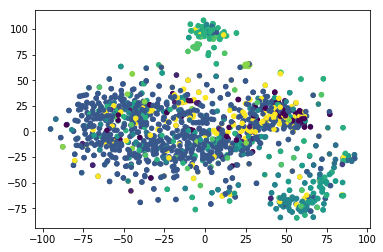

In [22]:
Plot.scatter(Y[:,0], Y[:,1], 20, c=df['label'])
Plot.show()